## 0. Import relevant libraries

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import random as rd
import pickle

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import splrep, BSpline, PchipInterpolator, CubicSpline
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from csaps import csaps

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## 1. Import features data

In [2]:
" Import data as Python pandas DataFrame "

_ADSORBATE_ = 'CO2'

LOC_STR = "/Users/arijitchakraborty/Library/CloudStorage/GoogleDrive-ac4758@columbia.edu/My Drive/Research/7_Zeolite_wTAMU_CES/Data/complete_data_avail.xlsx"
_DATA_ = pd.read_excel(LOC_STR, sheet_name=0, header=0, index_col='name')
            
_DATA = _DATA_[['density', 'spg', 'volume', 'pld', 'lcd', 'void_frac', 'surf_area_m2g',
       'surf_area_m2cm3', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere',
       'largest_included_sphere', 'largest_included_sphere_free']]


## 2. Import output variables' data

In [3]:
ADSORBATE_LOC_STR = "/Users/arijitchakraborty/Library/CloudStorage/GoogleDrive-ac4758@columbia.edu/My Drive/Research/7_Zeolite_wTAMU_CES/Data/"+ _ADSORBATE_ + ".xlsx"

ADSORBATE_xl = pd.ExcelFile(ADSORBATE_LOC_STR)
len(ADSORBATE_xl.sheet_names)  # sheet names


197

## 3. Obtain common adsorbents

In [4]:
_COMMON_ADSORBENTS = list(set(ADSORBATE_xl.sheet_names).intersection(_DATA.index))
print('There are ' + str(len(_COMMON_ADSORBENTS)) + ' common adsorbents.')


There are 190 common adsorbents.


### 3.1 Reindex based on common adsorbents

In [5]:
_DATA_REINDEXED = _DATA.reindex(_COMMON_ADSORBENTS)

print('Shape of the inputs is: ', _DATA_REINDEXED.shape)


Shape of the inputs is:  (190, 16)


## Load the data

Will only need to run this step in the future

In [6]:
with open('CO2_TRAIN.npy', 'rb') as TRAIN_FILE:
    TRAIN_ADSORBENTS = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_298K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_298K = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_323K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_323K = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_373K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_373K = np.load(TRAIN_FILE, allow_pickle=True)
    
with open('CO2_TEST.npy', 'rb') as TEST_FILE:
    TEST_ADSORBENTS = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_298K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_298K = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_323K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_323K = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_373K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_373K = np.load(TEST_FILE, allow_pickle=True)
    

In [7]:
TEST_ADSORBENTS

array(['VSV', 'DDR', 'AET', 'STI', 'GIU', 'FRA', 'SIV', 'SGT', 'IMF',
       'EMT', 'FER', 'DFO', 'MOZ', 'JBW', 'BIK', 'UWY', 'UOS', 'LTJ',
       'ATT', 'RWR', 'STW', 'JOZ', 'CAN', 'NPO', 'AFR', 'PCR', 'IFR',
       'TON', 'BOZ', 'SFF', 'LEV', 'AFS', 'NPT', 'AST', 'DON', 'MTF',
       'AFN', 'SSY'], dtype='<U3')

## Evaluate Results – 323 K

In [8]:
with open('CO2_RESULTS_323.npy', 'rb') as RESULTS_FILE:
    
    X_train = np.load(RESULTS_FILE, allow_pickle=True)
    X_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred = np.load(RESULTS_FILE, allow_pickle=True)
    y_train = np.load(RESULTS_FILE, allow_pickle=True)
    y_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_train = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_test = np.load(RESULTS_FILE, allow_pickle=True)
    P_TRAIN_STD = np.load(RESULTS_FILE, allow_pickle=True)


In [9]:
def predict_for_zeolite_323(_P_, normalized_features):
    
    P = _P_/P_TRAIN_STD
    
    density = normalized_features[0]; spg = normalized_features[1]; volume = normalized_features[2];
    pld = normalized_features[3]; lcd = normalized_features[4]; void_frac = normalized_features[5];
    surf_area_m2g = normalized_features[6]; surf_area_m2cm3 = normalized_features[7];
    ASA = normalized_features[8]; AV = normalized_features[9]; NASA = normalized_features[10];
    NAV = normalized_features[11]; VolFrac = normalized_features[12];
    largest_free_sphere = normalized_features[13]; largest_included_sphere = normalized_features[14]
    largest_included_sphere_free = normalized_features[15]
    
    f1 = ((((NASA)*(volume)/1) * P / (1 + ((NASA)*(volume)/1) * P)) - 0.5053560148639079)/0.4960635647959033; beta1 = 0.2408158535926262
    f2 = ((((NAV)/np.exp(largest_free_sphere)*((largest_included_sphere)**2)) * P / (1 + ((NAV)/np.exp(largest_free_sphere)*((largest_included_sphere)**2)) * P)) - 0.022023073277147264)/0.07412726445549916; beta2 = -0.6051468741071055
    f3 = (((np.exp(spg)*np.exp(-NASA)/np.exp(AV)) * P / (1 + (np.exp(spg)*np.exp(-NASA)/np.exp(AV)) * P)) - 0.636492475959887)/0.4788319028018178; beta3 = 0.17771546567926963
    f4 = ((((density)*(VolFrac)*1) * P / (1 + ((density)*(VolFrac)*1) * P)) - 0.15658870051279075)/0.13014735733464328; beta4 = -2.0804716603104425
    f5 = (((((lcd)**2)/1/np.exp(largest_free_sphere)) * P / (1 + (((lcd)**2)/1/np.exp(largest_free_sphere)) * P)) - 0.4486063640488222)/0.2755565010621821; beta5 = -0.35101203615301246
    f6 = ((((volume)/np.exp(density)/np.exp(VolFrac)) * P / (1 + ((volume)/np.exp(density)/np.exp(VolFrac)) * P)) - 0.769527662996705)/0.1914254994515539; beta6 = 1.1201332339583743
    f7 = ((((NASA)/np.exp(spg)/1) * P / (1 + ((NASA)/np.exp(spg)/1) * P)) - 0.018544154536591098)/0.1134031399766316; beta7 = 0.0023376143648303396
    f8 = (((((lcd)**2)/1/1) * P / (1 + (((lcd)**2)/1/1) * P)) - 0.9474631921424108)/0.11185899780233935; beta8 = -0.12134179550190091
    f9 = ((((pld)/(volume)*1) * P / (1 + ((pld)/(volume)*1) * P)) - 0.2259632424704171)/0.12819776041479525; beta9 = -1.215940666467515
    f10 = ((((void_frac)/1/1) * P / (1 + ((void_frac)/1/1) * P)) - 0.2983059470851118)/0.15314334975683067; beta10 = 2.3657034591203896
    f11 = (((1*1*1) * P / (1 + (1*1*1) * P)) - 0.561041654561111)/0.19904288999498684; beta11 = -0.6619785317203183
    f12 = ((((VolFrac)*1*1) * P / (1 + ((VolFrac)*1*1) * P)) - 0.10745167163360558)/0.09939185680979355; beta12 = 1.712890108697996
    intercept = 0
    theta = beta1*f1 + beta2*f2 + beta3*f3 + beta4*f4 + beta5*f5 + beta6*f6 + beta7*f7 + beta8*f8 + beta9*f9 + beta10*f10 + beta11*f11 + beta12*f12
    loading_at_zero_P = -beta1*0.5053560148639079/0.49606356479590331 + -beta2*0.022023073277147264/0.074127264455499162 + -beta3*0.636492475959887/0.47883190280181783 + -beta4*0.15658870051279075/0.130147357334643284 + -beta5*0.4486063640488222/0.27555650106218215 + -beta6*0.769527662996705/0.19142549945155396 + -beta7*0.018544154536591098/0.11340313997663167 + -beta8*0.9474631921424108/0.111858997802339358 + -beta9*0.2259632424704171/0.128197760414795259 + -beta10*0.2983059470851118/0.1531433497568306710 + -beta11*0.561041654561111/0.1990428899949868411 + -beta12*0.10745167163360558/0.0993918568097935512
    epsilon_max = 1
    d = np.abs(P - 0)
    alpha = 2
    yt = theta + intercept + np.mean(y_train) - np.abs(loading_at_zero_P + np.mean(y_train))* epsilon_max * np.exp(-alpha * d)
    
    return yt


# Specific Adsorbent

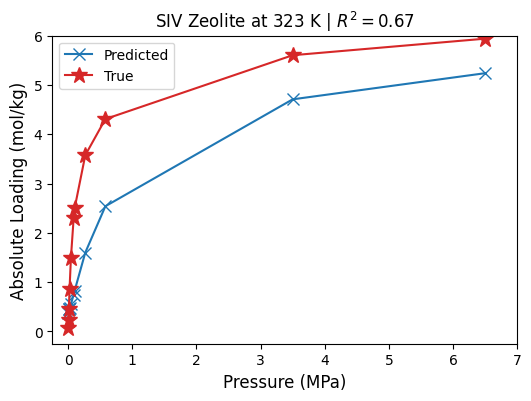

In [10]:
_specific_adsorbent_ = 'SIV'
plt.figure(figsize=(6,4), dpi=100)

CO2_OG_LOC_STR = r"/Users/arijitchakraborty/Library/CloudStorage/GoogleDrive-ac4758@columbia.edu/My Drive/Research/7_Zeolite_wTAMU_CES/Data/" + _ADSORBATE_ + ".xlsx"
CO2_temp_adsorbent_data = pd.read_excel(CO2_OG_LOC_STR, sheet_name=_specific_adsorbent_)

_specific_pressures_ = np.array([p for p in CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                                'Temperature (K)']==323]['Pressure (Pa)']])
predictions = [predict_for_zeolite_323(p, list(_DATA_REINDEXED.loc[_specific_adsorbent_])) for p in _specific_pressures_]

plt.plot(_specific_pressures_/1e6, predictions, label='Predicted', c='tab:blue', marker='x', markersize=8)

plt.plot(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']/1e6,
           CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Absolute Loading (mol/kg)'],
                   c='tab:red', label='True', marker='*', markersize=12)

plt.ylabel('Absolute Loading (mol/kg)', fontsize=12)
plt.xlabel('Pressure (MPa)', fontsize=12)

# plt.title(r'{:s} Zeolite at 323 K'.format(_specific_adsorbent_))

plt.title(r'{:s} Zeolite at 323 K | $R^{:d}={:.2f}$'.format(_specific_adsorbent_,2, r2_score(
                    CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323][
                        'Absolute Loading (mol/kg)'], [predict_for_zeolite_323(p, list(
                            _DATA_REINDEXED.loc[_specific_adsorbent_])) for p in CO2_temp_adsorbent_data[
                                CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']])))

plt.ylim(-0.25, 6)
plt.xlim(-0.25, 7)
plt.legend()
plt.show()

/var/folders/s6/wmy07hwx6j5fzckbkn3pv9540000gn/T/ipykernel_79401/3704734917.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,4), dpi=100)


CAN Input contains NaN.


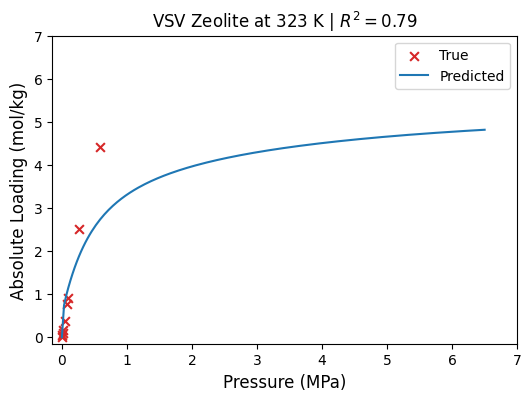

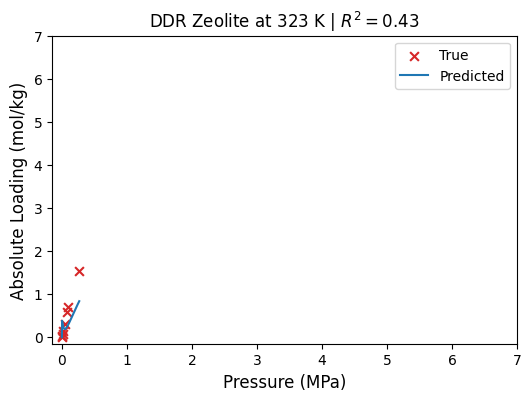

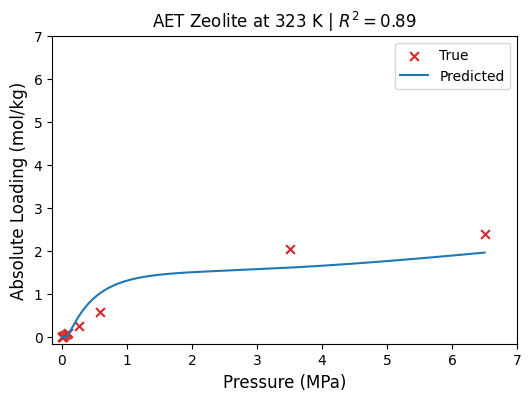

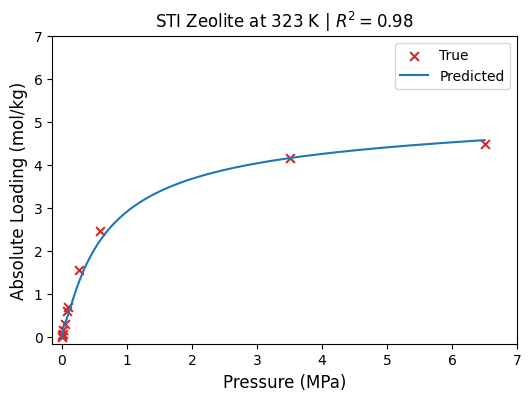

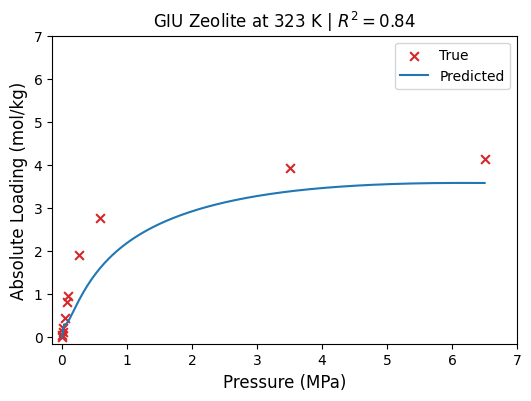

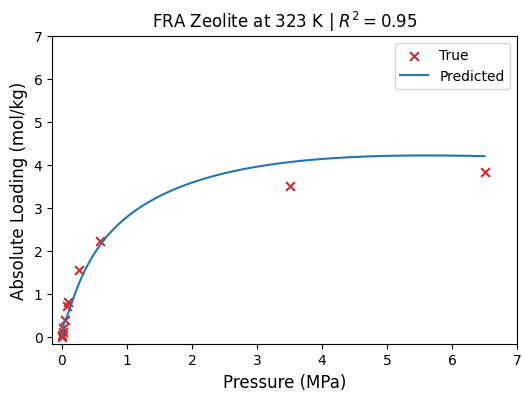

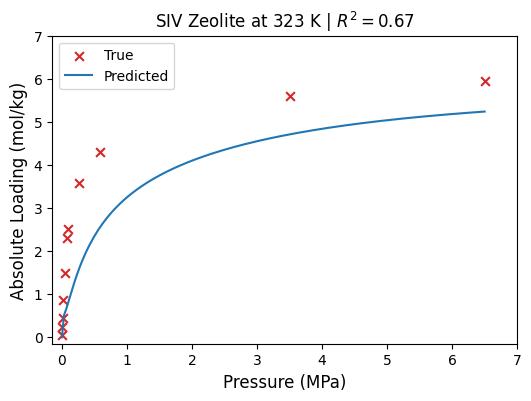

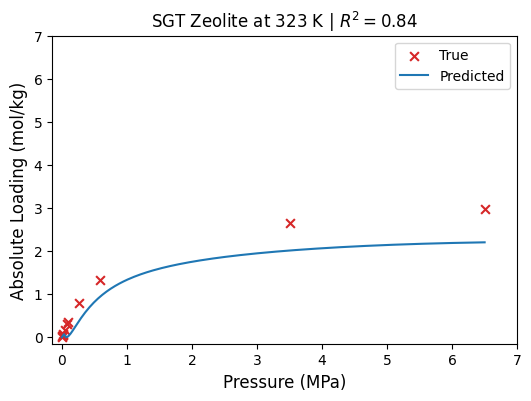

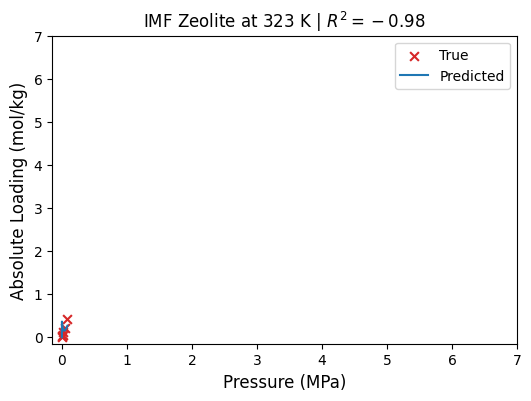

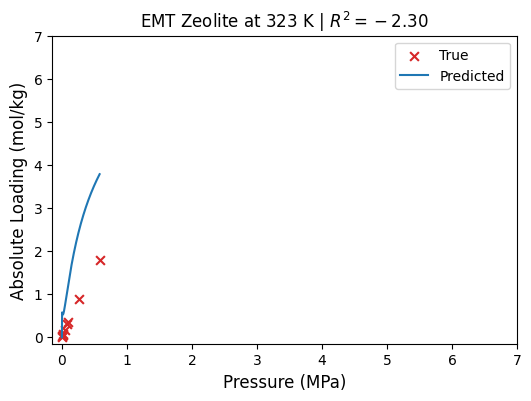

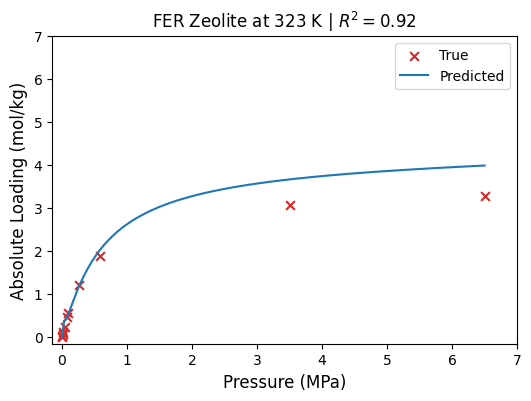

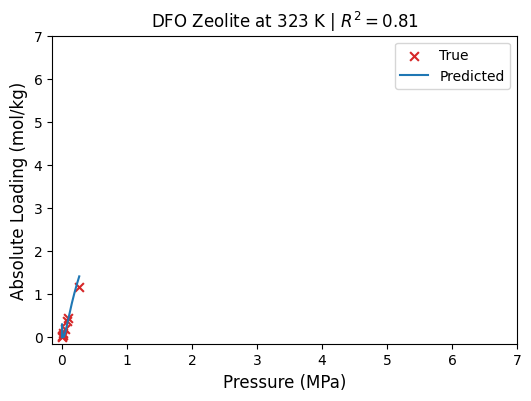

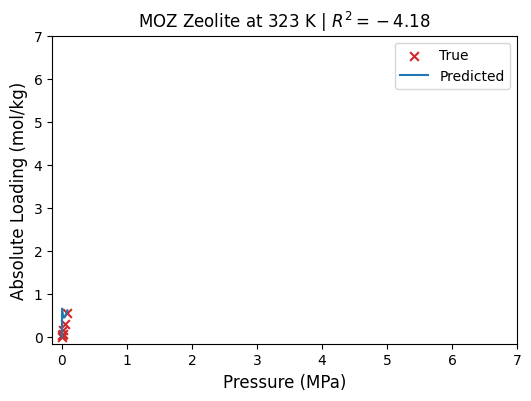

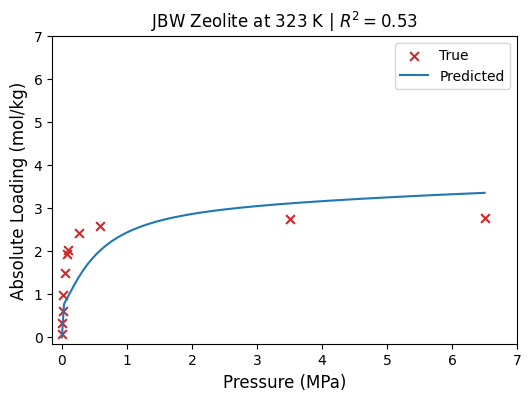

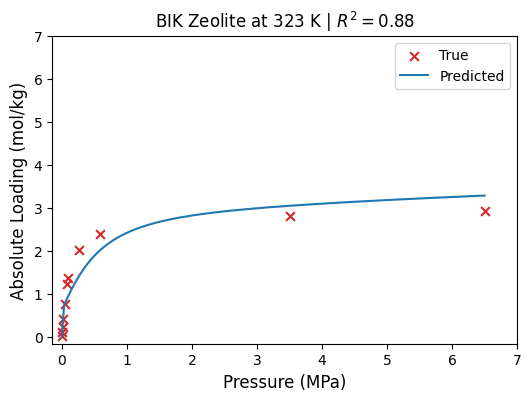

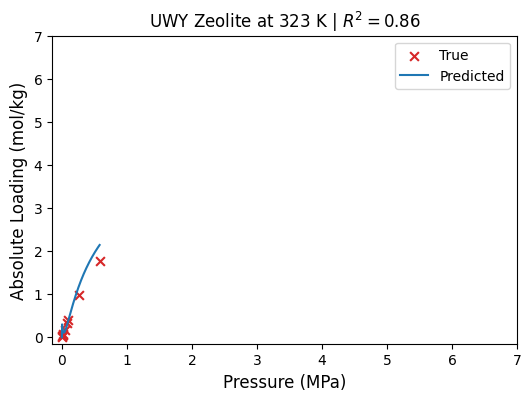

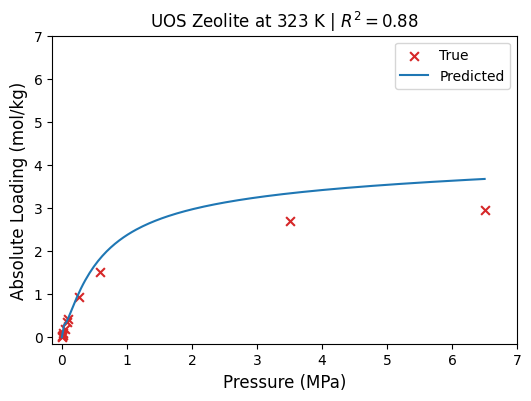

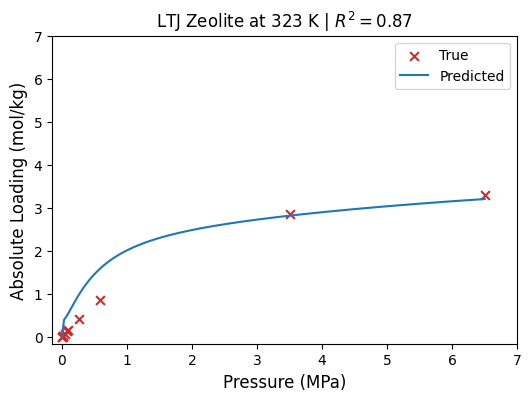

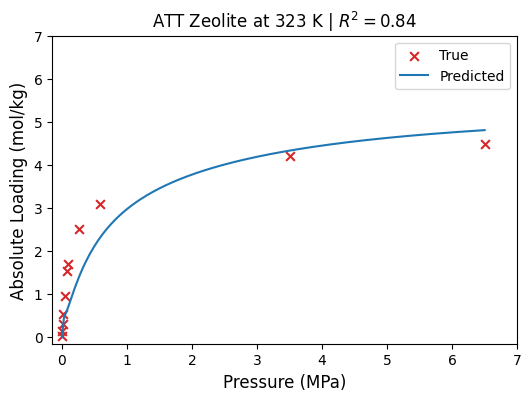

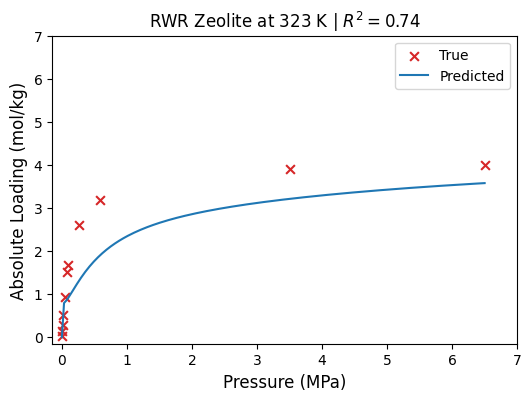

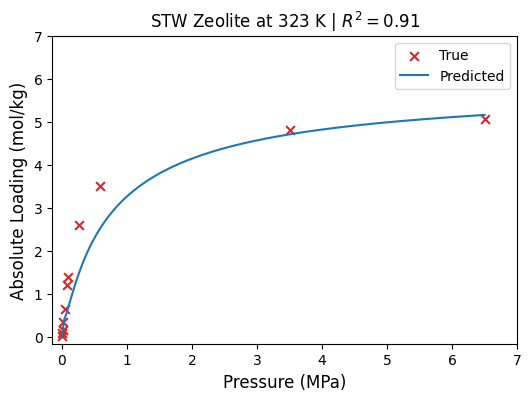

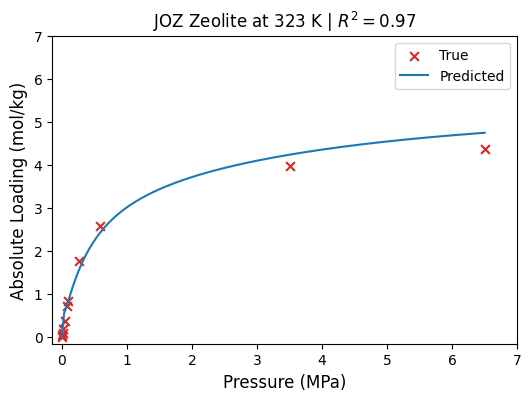

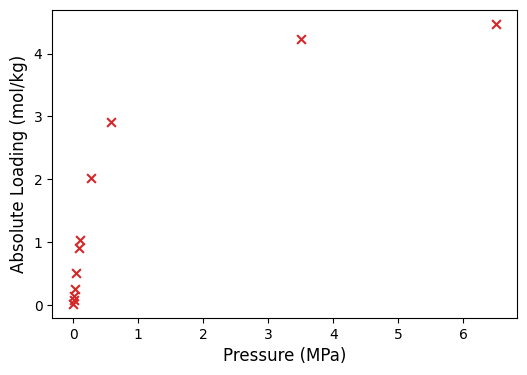

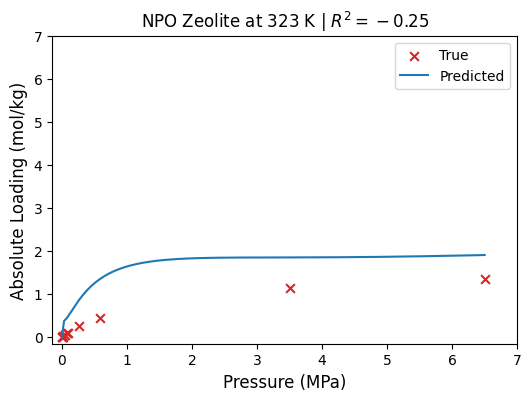

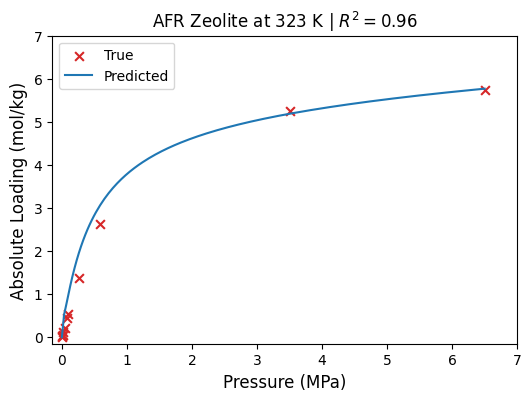

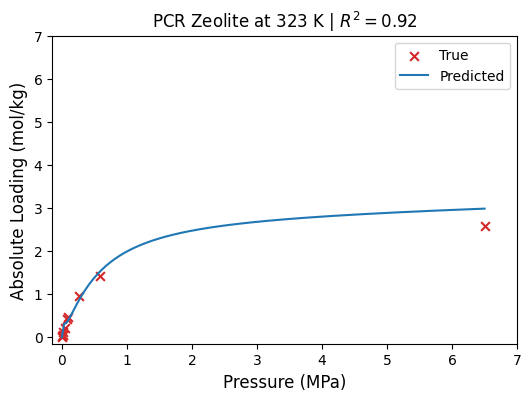

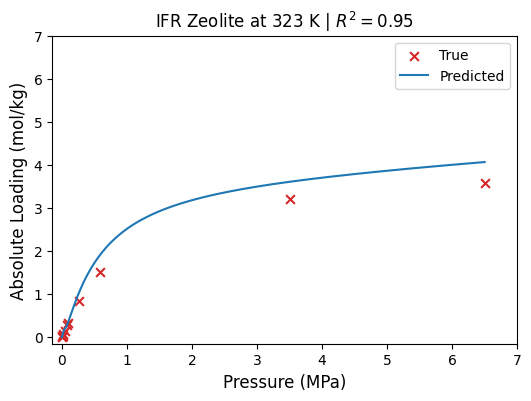

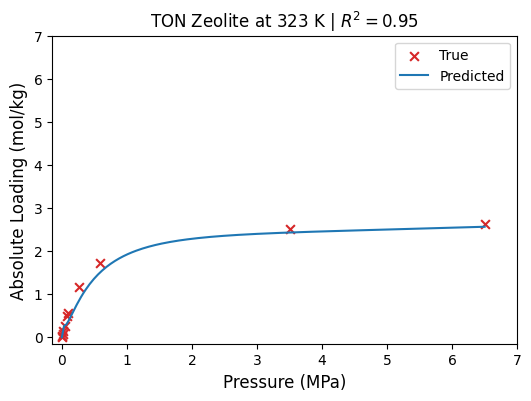

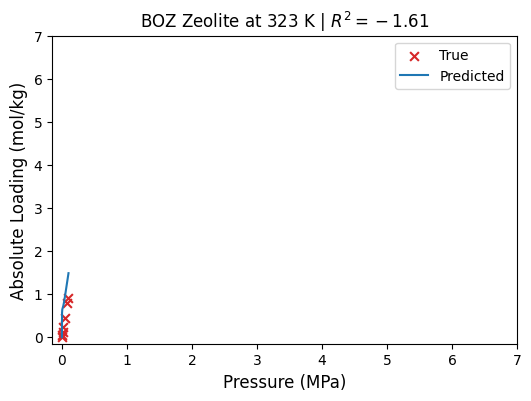

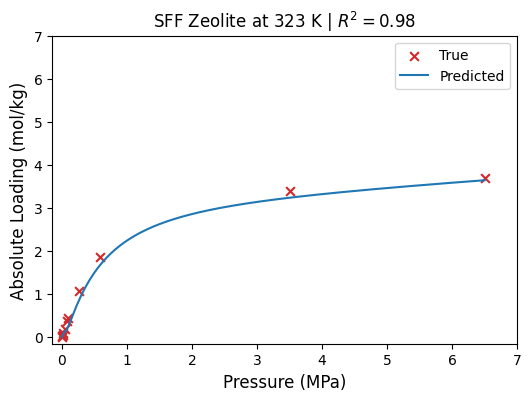

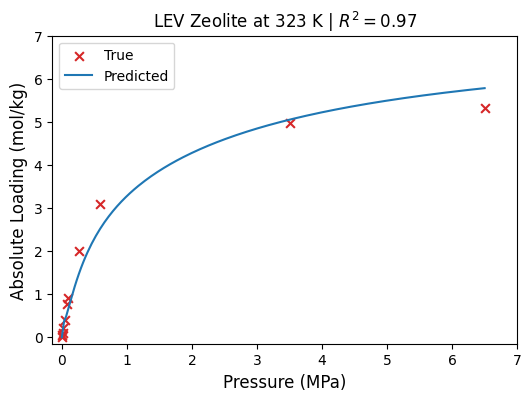

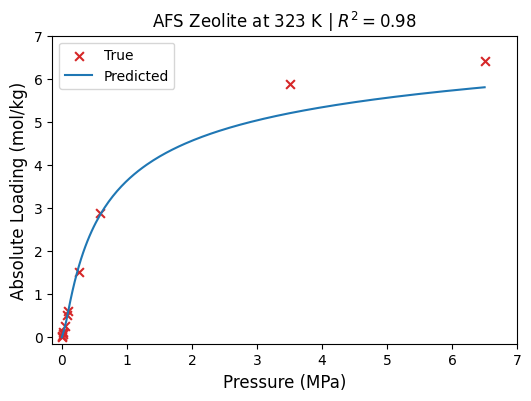

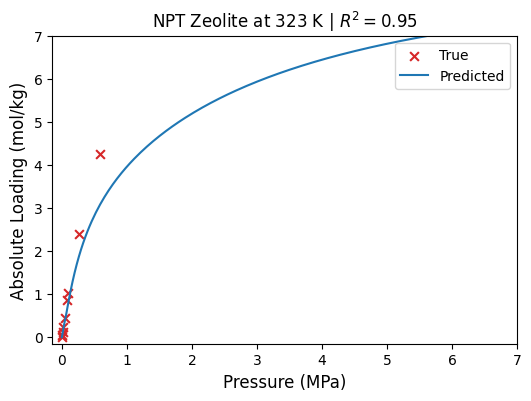

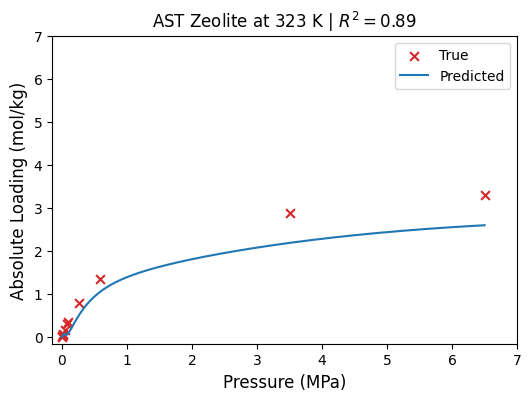

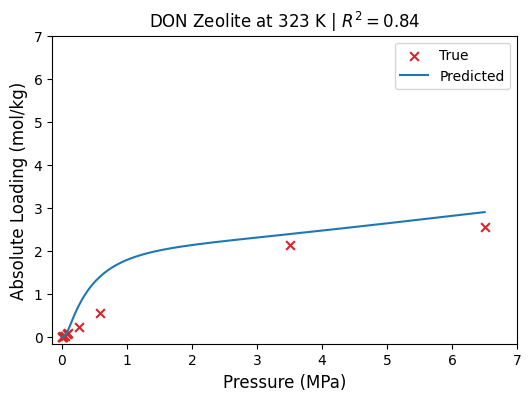

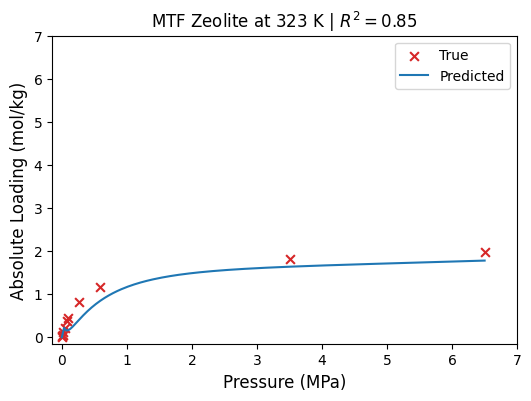

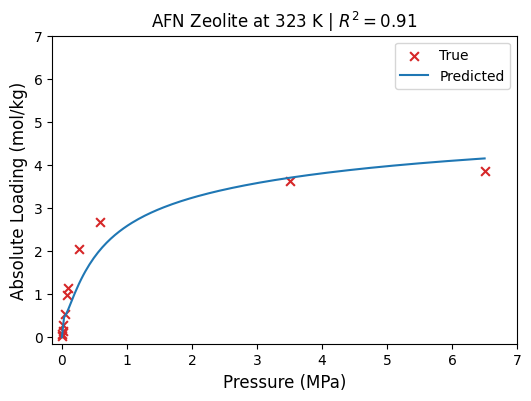

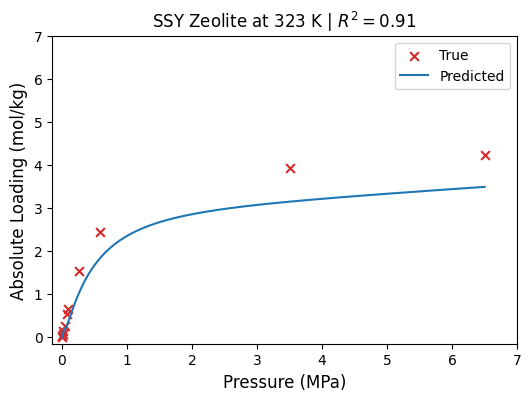

In [11]:
_323_real_ = []
_323_pred_ = []

for _test_z_ in TEST_ADSORBENTS:
# for _test_z_ in TRAIN_ADSORBENTS:
    
    try:
        plt.figure(figsize=(6,4), dpi=100)

        CO2_OG_LOC_STR = r"/Users/arijitchakraborty/Library/CloudStorage/GoogleDrive-ac4758@columbia.edu/My Drive/Research/7_Zeolite_wTAMU_CES/Data/" + _ADSORBATE_ + ".xlsx"
        CO2_temp_adsorbent_data = pd.read_excel(CO2_OG_LOC_STR, sheet_name=_test_z_)
        
        _specific_pressures_ = np.array([p for p in CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                                        'Temperature (K)']==323]['Pressure (Pa)']])
        _specific_predictions_ = [predict_for_zeolite_323(p, list(_DATA_REINDEXED.loc[_test_z_])) for p in _specific_pressures_]

        plt.scatter(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']/1e6,
                   CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Absolute Loading (mol/kg)'],
                           c='tab:red', label='True', marker='x', s=40)

        min_p = min(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)'])
        max_p = max(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)'])
        p_range = np.linspace(0, max_p, 200)
        predictions = [predict_for_zeolite_323(p, list(_DATA_REINDEXED.loc[_test_z_])) for p in p_range]

        plt.plot(p_range/1e6, predictions, label='Predicted', c='tab:blue')
        
        plt.ylabel('Absolute Loading (mol/kg)', fontsize=12)
        plt.xlabel('Pressure (MPa)', fontsize=12)
        
        plt.title(r'{:s} Zeolite at 323 K | $R^{:d}={:.2f}$'.format(_test_z_,2, r2_score(
                    CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323][
                        'Absolute Loading (mol/kg)'], [predict_for_zeolite_323(p, list(
                            _DATA_REINDEXED.loc[_test_z_])) for p in CO2_temp_adsorbent_data[
                                CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']])))

        _a_ = CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]
        _323_pred_.append(_specific_predictions_)
        _323_real_.append(_a_['Absolute Loading (mol/kg)'].tolist())
    
        plt.ylim(-0.15,7)
        plt.xlim(-0.15, 7)
        plt.legend()
    except Exception as e:
        print(_test_z_, e)


In [12]:
def flatten_concatenation(matrix):
    flat_list = []
    for row in matrix:
        flat_list += row
    return flat_list

_preds = np.array(flatten_concatenation(_323_pred_))
_real = np.array(flatten_concatenation(_323_real_))

_323_preds = np.array(flatten_concatenation(_323_pred_))
_323_real = np.array(flatten_concatenation(_323_real_))

new_test_real = np.delete(_323_real, np.argwhere(np.isnan(_323_real)))
new_test_preds = np.delete(_323_preds, np.argwhere(np.isnan(_323_real)))
new_new_test_real = np.delete(new_test_real, np.argwhere(np.isnan(new_test_preds)))
new_new_test_preds = np.delete(new_test_preds, np.argwhere(np.isnan(new_test_preds)))

print(r2_score(new_new_test_real, new_new_test_preds))
print(mean_absolute_error(new_new_test_real, new_new_test_preds))


0.8864052914544542
0.36388803423480354
